# Function for Basic Linear Regression on Cluster Plot
## Example Parameter: Avg Leaf Nitrogen Concentration (LNC) vs Leaf Carbon Nitrogen Ratio (LCN)
#### Author: Sofia Ingersoll, Sujan Bhattaria, & Heather Childers

##### Loading environment settings

In [1]:
# moved the libraries that were here into utils.py because they're essential
# xarray is required to run the utils import line
import xarray as xr
import pandas as pd
import glob
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.impute import SimpleImputer
#from sklearn_xarray import Stacker, Select

import matplotlib.pyplot as plt
from dask_jobqueue import PBSCluster
from dask.distributed import Client

utils.py needs to be in the same folder in order to call

In [2]:
# import libraries & data pre-processing functions from utils.py
from utils import *

### Leaf Carbon : Nitrogen Data 

This will come in handy later when we want to plot trends overtime

In [3]:
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# ----     load data stored in casper     ----
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
#-------Dummy Variable Data---------
#-------Leaf Carbon : Nitrogen Data---------
# x variable data for plotting
df = pd.read_csv('/glade/campaign/asp/djk2120/PPEn11/csvs/lhc220926.txt',index_col=0)
# convert to data set
params = xr.Dataset(df)

# the only dimension here is the 'member' aka file index id [LCH0001-500]
params

# subsetting for leafcn
leafcn = params['leafcn']

In [4]:
leafcn

<xarray.DataArray 'leafcn' (member: 500)>
array([0.15390372, 0.25647095, 0.58143673, 0.08038332, 0.50675542,
       0.25389407, 0.06140558, 0.24331545, 0.11321003, 0.13042747,
       0.43254369, 0.39358396, 0.76095491, 0.92870681, 0.57367004,
       0.8455355 , 0.68148672, 0.89776775, 0.56248474, 0.45862999,
       0.3700442 , 0.29728894, 0.6629277 , 0.69784644, 0.43024439,
       0.51180049, 0.78351025, 0.09426476, 0.17934387, 0.48424082,
       0.74072378, 0.63758525, 0.37942745, 0.38894863, 0.42236335,
       0.92192411, 0.0494406 , 0.27530503, 0.69245834, 0.72266726,
       0.0373934 , 0.17492506, 0.28669653, 0.50473363, 0.18126413,
       0.60802933, 0.02112097, 0.98810547, 0.84900562, 0.84000835,
       0.80191261, 0.37281976, 0.53767195, 0.63400201, 0.35150317,
       0.54518256, 0.3917908 , 0.00610258, 0.53994752, 0.57844688,
       0.84351799, 0.20523043, 0.30292921, 0.09102867, 0.99373039,
       0.75679072, 0.86807206, 0.0243698 , 0.59060441, 0.7708944 ,
       0.80922007, 0.72851373, 0.56790867, 0.99912806, 0.05378535,
       0.07755333, 0.95482988, 0.33538958, 0.32139355, 0.24664123,
       0.16139783, 0.71350258, 0.89124166, 0.63365399, 0.91110741,
       0.74792208, 0.43969515, 0.68203052, 0.79336275, 0.30811891,
       0.19313768, 0.41296641, 0.24854964, 0.6540496 , 0.62373253,
       0.12429787, 0.73490479, 0.4012098 , 0.93910465, 0.97846495,
...
       0.85966967, 0.29301485, 0.98256805, 0.52500917, 0.45733315,
       0.49038934, 0.50859997, 0.16384773, 0.2893779 , 0.54618347,
       0.00984029, 0.08814156, 0.23547435, 0.91293942, 0.01771003,
       0.05833041, 0.78414676, 0.0926864 , 0.20030708, 0.87154307,
       0.53310827, 0.55010633, 0.32425522, 0.49358677, 0.52300912,
       0.34189665, 0.59919699, 0.74595893, 0.75069269, 0.78964455,
       0.44355568, 0.4523614 , 0.74819211, 0.23379476, 0.66463734,
       0.52805873, 0.28544364, 0.72788353, 0.31303326, 0.31063496,
       0.50270814, 0.46229379, 0.66921457, 0.54290931, 0.96592771,
       0.56069616, 0.81483848, 0.74256203, 0.21433953, 0.43586343,
       0.405011  , 0.62080754, 0.13802383, 0.60130278, 0.64292925,
       0.63059251, 0.02344936, 0.90992794, 0.21836893, 0.76881562,
       0.58314723, 0.03239475, 0.59372823, 0.36392503, 0.70901907,
       0.62530452, 0.95905959, 0.35784141, 0.86244023, 0.50073362,
       0.33274091, 0.34443394, 0.20654864, 0.38455274, 0.9147936 ,
       0.46689402, 0.48257372, 0.45105802, 0.57747691, 0.87355857,
       0.44606519, 0.8805903 , 0.0382621 , 0.18381204, 0.33925879,
       0.35431454, 0.47661711, 0.06402443, 0.72147781, 0.24198474,
       0.93674884, 0.09808559, 0.32251814, 0.4801311 , 0.80384233,
       0.77535798, 0.12737383, 0.26952464, 0.9732964 , 0.13606501])
Coordinates:
  * member   (member) object 'LHC0001' 'LHC0002' ... 'LHC0499' 'LHC0500'

##### Request additional processing power from server

In [5]:
# Request an additional 10 cores of power for processing from the server
client = get_cluster("UCSB0021", cores = 40)

In [6]:
# apply peer2peer network communication across multiple devices
client.cluster

Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/singersoll/proxy/8787/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://128.117.208.112:42589,Workers: 0
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/singersoll/proxy/8787/status,Total threads: 0
Started: 1 minute ago,Total memory: 0 B


## Loading a Cluster of 500 files
The data files are located in `/glade/campaign/cgd/tss/projects/PPE/PPEn11_LHC/transient/hist/`

The 2005-2010 monthly output files have the form:
`PPEn11_transient_LHC0001.clm2.h0.2005-02-01-00000.nc`

We're interested in files spanning from:
`LHC0001 to LHC0500`

This part is working perfectly

In [5]:
# read all simulations as a list
cluster_list = sorted(glob.glob('/glade/campaign/cgd/tss/projects/PPE/PPEn11_LHC/transient/hist/PPEn11_transient_LHC[0][0-5][0-9][0-9].clm2.h0.2005-02-01-00000.nc'))
cluster_list = cluster_list[1:len(cluster_list)]
#cluster_list

In [6]:
# creating cluster
#read the list and load it for the notebook
LNC = xr.open_mfdataset(cluster_list, 
                                   combine='nested',
                                   parallel=True, 
                                   concat_dim="ens")

In [7]:
# confirming that the ensemble loaded correctly! yay! ens: 500 
LNC

<xarray.Dataset>
Dimensions:                            (levgrnd: 25, levsoi: 20, levlak: 10,
                                        levdcmp: 25, time: 60, ens: 500,
                                        hist_interval: 2, lon: 144, lat: 96,
                                        gridcell: 400, landunit: 1267,
                                        column: 2974, pft: 8574, cft: 2,
                                        ltype: 9, nvegwcs: 4)
Coordinates:
  * levgrnd                            (levgrnd) float32 0.01 0.04 ... 42.0
  * levsoi                             (levsoi) float32 0.01 0.04 ... 6.94 8.03
  * levlak                             (levlak) float32 0.05 0.6 ... 34.33 44.78
  * levdcmp                            (levdcmp) float32 0.01 0.04 ... 42.0
  * time                               (time) object 2005-02-01 00:00:00 ... ...
  * lon                                (lon) float32 0.0 2.5 5.0 ... 355.0 357.5
  * lat                                (lat) float32 -90.0 -88.11 ... 88.11 90.0
Dimensions without coordinates: ens, hist_interval, gridcell, landunit, column,
                                pft, cft, ltype, nvegwcs
Data variables: (12/497)
    mcdate                             (ens, time) int32 dask.array<chunksize=(1, 60), meta=np.ndarray>
    mcsec                              (ens, time) int32 dask.array<chunksize=(1, 60), meta=np.ndarray>
    mdcur                              (ens, time) int32 dask.array<chunksize=(1, 60), meta=np.ndarray>
    mscur                              (ens, time) int32 dask.array<chunksize=(1, 60), meta=np.ndarray>
    nstep                              (ens, time) int32 dask.array<chunksize=(1, 60), meta=np.ndarray>
    time_bounds                        (ens, time, hist_interval) object dask.array<chunksize=(1, 60, 2), meta=np.ndarray>
    ...                                 ...
    XSMRPOOL                           (ens, time, gridcell) float32 dask.array<chunksize=(1, 60, 400), meta=np.ndarray>
    XSMRPOOL_RECOVER                   (ens, time, gridcell) float32 dask.array<chunksize=(1, 60, 400), meta=np.ndarray>
    ZBOT                               (ens, time, gridcell) float32 dask.array<chunksize=(1, 60, 400), meta=np.ndarray>
    ZWT                                (ens, time, gridcell) float32 dask.array<chunksize=(1, 60, 400), meta=np.ndarray>
    ZWT_CH4_UNSAT                      (ens, time, gridcell) float32 dask.array<chunksize=(1, 60, 400), meta=np.ndarray>
    ZWT_PERCH                          (ens, time, gridcell) float32 dask.array<chunksize=(1, 60, 400), meta=np.ndarray>
Attributes: (12/40)
    title:                                     CLM History file information
    comment:                                   NOTE: None of the variables ar...
    Conventions:                               CF-1.0
    history:                                   created on 08/10/23 00:09:45
    source:                                    Community Terrestrial Systems ...
    hostname:                                  cheyenne
    ...                                        ...
    ctype_urban_pervious_road:                 75
    cft_c3_crop:                               1
    cft_c3_irrigated:                          2
    time_period_freq:                          month_1
    Time_constant_3Dvars_filename:             ./PPEn11_transient_LHC0001.clm...
    Time_constant_3Dvars:                      ZSOI:DZSOI:WATSAT:SUCSAT:BSW:H...

In [ ]:
test = get_ensemble('LNC')

## Wrangling Cluster for Avg LNC with properly weighted dimensions (time & gridcell) 

### Applying data processing functions from utils
At this point in time, only the `fix_time()` function may be successfully applied to the cluster ensemble.

In [8]:
# testing to see if our functions can be applied to an ensemble
# time bug fixer funct
LNC = fix_time(LNC)                   # I don't think I need to set it equal because the function says return da, but just incase 

In [ ]:
# they can! the time bug was fixed :-) 
# we can see this in the time dimension
# our ens now starts in January instead of February
LNC

In [ ]:
# testing weighting time
LNC = yearly_weighted_average(LNC)

In [ ]:
# weighting grid cells
LNC = weight_landarea_gridcells(LNC, landarea)

### Subsetting a Data Array from the Dataset
As an output, we expect an ensemble of 500 containing 400 gridcells

In [9]:
# take an average Dataset's time dimension 
LNC_avg = LNC.mean(dim = 'time')

In [10]:
# create a data array of our variable of interest LNC
LNC_da = LNC_avg['LNC']

In [11]:
# confirming subset data array contains 500 ens points and 400 grid cells!
LNC_da 

<xarray.DataArray 'LNC' (ens: 500, gridcell: 400)>
dask.array<mean_agg-aggregate, shape=(500, 400), dtype=float32, chunksize=(1, 400), chunktype=numpy.ndarray>
Dimensions without coordinates: ens, gridcell

In [15]:
# create a data array of our variable of interest LNC
leafcn_da = LNC['LEAFCN']

In [13]:
# confirming subset data array contains 500 ens points and 400 grid cells!
leafcn_da 

<xarray.DataArray 'LEAFCN' (ens: 500, gridcell: 400)>
dask.array<mean_agg-aggregate, shape=(500, 400), dtype=float32, chunksize=(1, 400), chunktype=numpy.ndarray>
Dimensions without coordinates: ens, gridcell

In [16]:
leafcn_avg = leafcn_da.mean(dim = 'time')

### Visualize Cluster Plot with Linear Regression
I confirmed that the leafcn data provided and LNC are the same length, but it's not running. I am going to create a data array from the cluster files read in 

#### Funkiness Explained
I was not able to get the given data to work, so I subset the cluster data and this is too noisy.

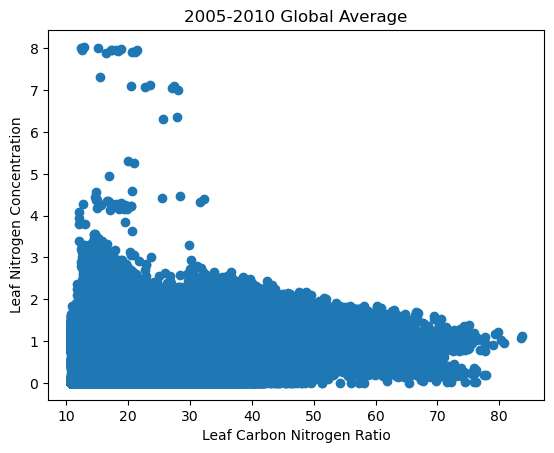

In [17]:
plt.scatter(x = leafcn_avg,
            y = LNC_da)

# Set plot labels and title
plt.xlabel('Leaf Carbon Nitrogen Ratio')
plt.ylabel('Leaf Nitrogen Concentration')
plt.title('2005-2010 Global Average')

# Show the plot
plt.show()

ValueError: x and y must be the same size

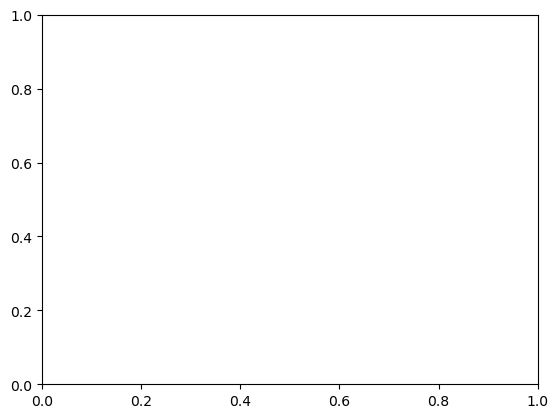

In [44]:
plt.scatter(x = leafcn,
            y = LNC_da)

# Set plot labels and title
plt.xlabel('Leaf Carbon Nitrogen Ratio')
plt.ylabel('Leaf Nitrogen Concentration')
plt.title('2005-2010 Global Average')

# Show the plot
plt.show()

#### Trying to understand why my evenly matched ensembles are not plotting bc uneven

In [45]:
# Check for NaN values in leafcn
nan_indices_leafcn = np.isnan(leafcn)
print("NaN values in leafcn:", np.sum(nan_indices_leafcn))

# Check for NaN values in LNC_da
nan_indices_LNC_da = np.isnan(LNC_da)
print("NaN values in LNC_da:", np.sum(nan_indices_LNC_da))

NaN values in leafcn: <xarray.DataArray 'leafcn' ()>
array(0)
NaN values in LNC_da: <xarray.DataArray 'LNC' ()>
dask.array<sum-aggregate, shape=(), dtype=int64, chunksize=(), chunktype=numpy.ndarray>


## Linear Regression
Linear Regression only works when both of the data arrays being passed do not contain NaN values. This might also be the issue preventing us from plotting above. I am going to try using the `SimpleImputer()` function to replace missing values with the mean values of this column. A variety of stats options may be selected to fill this instead. I've choosen mean for now. This still didn't work

/glade/u/home/singersoll/.conda/envs/meds-py/lib/python3.11/site-packages/sklearn/impute/_base.py:565: UserWarning: Skipping features without any observed values: [ 76 105 357 360 365 371 384 385 388]. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
/glade/u/home/singersoll/.conda/envs/meds-py/lib/python3.11/site-packages/sklearn/impute/_base.py:565: UserWarning: Skipping features without any observed values: [ 76 105 357 360 365 371 384 385 388]. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
/glade/u/home/singersoll/.conda/envs/meds-py/lib/python3.11/site-packages/sklearn/impute/_base.py:565: UserWarning: Skipping features without any observed values: [ 76 105 357 360 365 371 384 385 388 398]. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
/glade/u/home/singersoll/.conda/envs/meds-py/lib/python3.11/site-packages/sklearn/impute/_base.py:565: Us

ValueError: x and y must be the same size

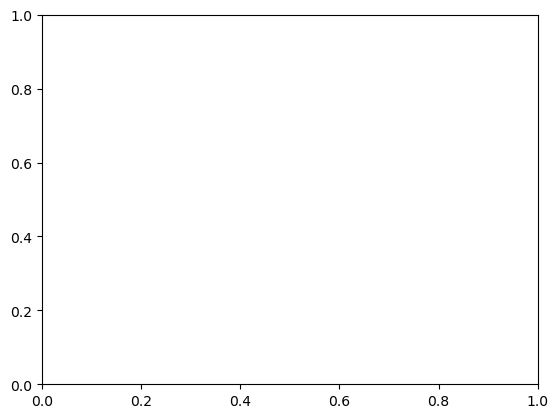

In [61]:
# Assuming leafcn_da and LNC_da are your pre-processed data arrays
# Make sure that leafcn_da and LNC_da have the same length and are 1D arrays
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# ----      Split Data 90/10        ----
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
X_train, X_test, y_train, y_test = train_test_split(leafcn_da, LNC_da, test_size=0.1, random_state=0)

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# ----         Removing NaN         ----
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# Handle NaN values using SimpleImputer
imputer = SimpleImputer(strategy='mean')  # You can choose other strategies like 'median' or 'most_frequent'
X_train_imputed = imputer.fit_transform(X_train)
X_test_imputer = imputer.fit_transform(X_test)

y_train_imputed = imputer.fit_transform(y_train)
y_test_imputed = imputer.fit_transform(y_test)

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# ----      Linear Regression       ----
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
regressor = LinearRegression()
regressor.fit(X_train_imputed, y_train_imputed)

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# ----       Make Predictions       ----
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
y_pred = regressor.predict(X_test_imputed)

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# ----    Plot Linear Regression    ----
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
plt.scatter(X_train_imputed, y_train_imputed, color='g', label='Training Data')
plt.scatter(X_test_imputed, y_test_imputed, color='b', label='Testing Data')
plt.plot(X_test_imputed, y_pred, color='k', linewidth=2, label='Linear Regression')

plt.xlabel('leafcn')
plt.ylabel('LNC_da')
plt.title('Linear Regression for LNC')
plt.legend()
plt.show()

In [55]:
# Handle NaN values in features using SimpleImputer
imputer = SimpleImputer(strategy='mean')
X_train_imputed = imputer.fit_transform(X_train)
X_test_imputed = imputer.transform(X_test)

# Handle NaN values in the target variable (y_train)
nan_indices_y_train = np.isnan(y_train)
X_train_imputed = X_train_imputed[~nan_indices_y_train]
y_train = y_train[~nan_indices_y_train]

# Handle NaN values in the target variable (y_test)
nan_indices_y_test = np.isnan(y_test)
X_test_imputed = X_test_imputed[~nan_indices_y_test]
y_test = y_test[~nan_indices_y_test]

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# ----      Linear Regression       ----
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
regressor = LinearRegression()
regressor.fit(X_train_imputed, y_train)

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# ----       Make Predictions       ----
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
y_pred = regressor.predict(X_test_imputed)

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# ----    Plot Linear Regression    ----
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
plt.scatter(X_train_imputed, y_train, color='g', label='Training Data')
plt.scatter(X_test_imputed, y_test, color='b', label='Testing Data')
plt.plot(X_test_imputed, y_pred, color='k', linewidth=2, label='Linear Regression')

plt.xlabel('leafcn')
plt.ylabel('LNC_da')
plt.title('Linear Regression for LNC')
plt.legend()
plt.show()

/glade/u/home/singersoll/.conda/envs/meds-py/lib/python3.11/site-packages/sklearn/impute/_base.py:565: UserWarning: Skipping features without any observed values: [ 76 105 357 360 365 371 384 385 388]. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
/glade/u/home/singersoll/.conda/envs/meds-py/lib/python3.11/site-packages/sklearn/impute/_base.py:565: UserWarning: Skipping features without any observed values: [ 76 105 357 360 365 371 384 385 388]. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(


IndexError: boolean index did not match indexed array along dimension 1; dimension is 391 but corresponding boolean dimension is 400

### Functions

Maybe I'm not applying the function correctly, but the object cluster_list is not callable outside of the function

In [ ]:
# modify the function if you want to pass the parameter
def read_all_simulation(var):
    '''prepare cluster list and read to create ensemble(group of data)
    use preprocess to select only certain dimension and a variable'''
    # read all simulations as a list
    cluster_list = sorted(glob.glob('/glade/campaign/cgd/tss/projects/PPE/PPEn11_LHC/transient/hist/PPEn11_transient_LHC[0][0-5][0-9][0-9].clm2.h0.2005-02-01-00000.nc'))
    cluster_list = cluster_list[1:len(cluster_list)]

    # only select latitude, longitude, time, and  using this in preprocess steps
    def preprocess_cluster (ds, var):
        '''using this function in xr.open_mfdataset as preprocess
        ensures that when only these four things are selected 
        before the data is combined'''
        return ds[['lat', 'lon', 'time', var]]

    # creating cluster
    #read the list and load it for the notebook
    xr.open_mfdataset( cluster_list, 
                                   combine='nested',
                                   preprocess = lambda ds: preprocess_cluster(ds, var),
                                   parallel=False, 
                                   concat_dim="ens")

In [ ]:
# apply nested function to generate cluster list 
LNC = read_all_simulation('LNC')

In [ ]:
# creating cluster
#read the list and load it for the notebook
LNC = xr.open_mfdataset( cluster_list, 
                                   combine='nested',
                                   preprocess = lambda ds: preprocess_cluster(ds, LNC),
                                   parallel=False, 
                                   concat_dim="ens")

Making this a functiondef get_ensemble(datavars):
    '''Fetch the latin hypercube ensemble subset for the requested datavars. 
    
    Keyword arguments:
    datavars -- list of CLM variables, e.g. ['GPP','SOILWATER_10CM']

    Returns:
    ds -- an xarray dataset of the subsetted ensemble
    '''
    def subset(ds):
        return ds[datavars]
    d = '/glade/campaign/cgd/tss/projects/PPE/PPEn11_LHC/transient/hist/'
    f = 'PPEn11_transient_LHC{}.clm2.h0.2010-02-01-00000.nc'
    files = [???]
    ds = xr.open_mfdataset(files, combine='nested', concat_dim='member',
                           preprocess=subset, parallel=True)
    return ds



In [ ]:
def get_ensemble(datavars):
    '''Fetch the latin hypercube ensemble subset for the requested datavars. 
    
    Keyword arguments:
    datavars -- list of CLM variables, e.g. [GPP','SOILWATER_10CM']

    Returns:
    ds -- an xarray dataset of the subsetted ensemble
    '''
    def subset(ds):
        return ds[datavars]
    d = '/glade/campaign/cgd/tss/projects/PPE/PPEn11_LHC/transient/hist/'
    f = 'PPEn11_transient_LHC{}.clm2.h0.2010-02-01-00000.nc'
    files = [0][0-5][0-9][0-9]
    ds = xr.open_mfdataset(files, combine='nested', concat_dim='member',
                           preprocess=subset, parallel=True)
    return ds